## Step 0 — Setup (Installs & Imports)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

print("✅ NumPy:", np.__version__)
print("✅ Pandas:", pd.__version__)
print("✅ TensorFlow:", tf.__version__)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


✅ NumPy: 1.26.4
✅ Pandas: 2.3.2
✅ TensorFlow: 2.17.0


## Step 1 — Load Dataset

In [ ]:
# 👉 Put your dataset path here
dataset_path = "/content/dataset 5.csv"

# Try CSV first, then TSV
try:
    df = pd.read_csv(dataset_path, encoding='latin-1')
except Exception:
    try:
        df = pd.read_csv(dataset_path, sep='\t', header=None, names=['label','text'], encoding='utf-8')
    except Exception as e:
        raise RuntimeError("Could not parse the file automatically. Please ensure it's CSV or TSV.") from e

# Normalize columns to ['label','text']
if 'label' in df.columns and 'text' in df.columns:
    pass
elif {'v1','v2'}.issubset(df.columns):
    df = df.rename(columns={'v1':'label','v2':'text'})
    df = df[['label','text']]
elif df.shape[1] >= 2:
    df = df.iloc[:, :2]
    df.columns = ['label','text']
else:
    raise ValueError("Dataset must have at least two columns: label and text/message.")

# Clean NaNs & normalize labels
df = df.dropna(subset=['label','text']).copy()
df['label'] = df['label'].str.strip().str.lower().map({'spam':'spam','ham':'ham','1':'spam','0':'ham'}).fillna(df['label'].str.strip().str.lower())

# Keep only ham/spam rows
df = df[df['label'].isin(['ham','spam'])].copy()
df = df.reset_index(drop=True)

print(df.head())
print(df['label'].value_counts())
print("Total samples:", len(df))


  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
label
ham     4825
spam     747
Name: count, dtype: int64
Total samples: 5572


## Step 2 — Clean text

In [ ]:
import re, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download the missing resource

STOPWORDS = set(stopwords.words('english'))
lemm = WordNetLemmatizer()

URL_RE = re.compile(r'https?://\S+|www\.\S+')
EMAIL_RE = re.compile(r'\S+@\S+')
NUM_RE = re.compile(r'\d+')
PUNCT_RE = re.compile(r'[^\w\s]')

def preprocess_text(text: str) -> str:
    text = text.lower()
    text = URL_RE.sub(' ', text)
    text = EMAIL_RE.sub(' ', text)
    text = NUM_RE.sub(' ', text)
    text = PUNCT_RE.sub(' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    tokens = [lemm.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df['clean'] = df['text'].astype(str).apply(preprocess_text)
df[['label','text','clean']].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,label,text,clean
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('clean').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('label')):
  _plot_series(series, series_name, i)
  fig.legend(title='label', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('text')):
  _plot_series(series, series_name, i)
  fig.legend(title='text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('clean')):
  _plot_series(series, series_name, i)
  fig.legend(title='clean', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_7['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['text'].value_counts()
    for x_label, grp in _df_8.groupby('label')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('label')
_ = plt.ylabel('text')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['clean'].value_counts()
    for x_label, grp in _df_9.groupby('text')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('text')
_ = plt.ylabel('clean')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='index', y='label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='index', y='text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['clean'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='index', y='clean', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## Step 3 — Train/Test split (stratified)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['clean'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

print("Train:", y_train.value_counts().to_dict())
print("Test :", y_test.value_counts().to_dict())


Train: {'ham': 3859, 'spam': 598}
Test : {'ham': 966, 'spam': 149}


## Helper — Metrics & Confusion Matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_and_report(y_true, y_pred, title="Model"):
    print(f"\n=== {title} ===")
    print(classification_report(y_true, y_pred, digits=4))
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    cm = confusion_matrix(y_true, y_pred, labels=['ham','spam'])
    fig, ax = plt.subplots(figsize=(4.5,4))
    im = ax.imshow(cm)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['ham','spam']); ax.set_yticklabels(['ham','spam'])
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(f'{title} — Confusion Matrix')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i,j]>cm.max()/2 else "black")
    fig.colorbar(im)
    plt.show()
    return acc


## Step 4A — TF-IDF features

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
Xtr_tfidf = tfidf.fit_transform(X_train)
Xte_tfidf = tfidf.transform(X_test)
Xtr_tfidf.shape, Xte_tfidf.shape


((4457, 7073), (1115, 7073))

## Step 4B — Word2Vec Mean Embeddings (dense) + SMOTE

In [ ]:
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE

# Tokenize
X_train_tokens = [s.split() for s in X_train.tolist()]
X_test_tokens  = [s.split() for s in X_test.tolist()]

# Train Word2Vec on training texts
w2v_size = 100
w2v = Word2Vec(sentences=X_train_tokens, vector_size=w2v_size, window=5, min_count=2, workers=4, sg=1, seed=42)

def sent_vec(tokens, model, dim):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(dim)

Xtr_w2v = np.vstack([sent_vec(toks, w2v, w2v_size) for toks in X_train_tokens])
Xte_w2v = np.vstack([sent_vec(toks, w2v, w2v_size) for toks in X_test_tokens])

# Apply SMOTE on training set only (use integer labels)
y_train_int = (y_train.values == 'spam').astype(int)
sm = SMOTE(random_state=42)
Xtr_w2v_sm, ytr_sm = sm.fit_resample(Xtr_w2v, y_train_int)

# Map back to labels
ytr_sm_lab = np.where(ytr_sm==1, 'spam', 'ham')

Xtr_w2v.shape, Xte_w2v.shape, Xtr_w2v_sm.shape, np.bincount(ytr_sm)


((4457, 100), (1115, 100), (7718, 100), array([3859, 3859]))

## Step 4C — Sequences for LSTM + Class Weights

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 20000
max_len = 60

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train.tolist())

Xtr_seq = tokenizer.texts_to_sequences(X_train.tolist())
Xte_seq = tokenizer.texts_to_sequences(X_test.tolist())

Xtr_pad = pad_sequences(Xtr_seq, maxlen=max_len, padding='post', truncating='post')
Xte_pad = pad_sequences(Xte_seq, maxlen=max_len, padding='post', truncating='post')

y_train_bin = (y_train.values == 'spam').astype(int)
y_test_bin  = (y_test.values == 'spam').astype(int)

# Class weights for LSTM
from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight(class_weight='balanced', classes=np.array([0,1]), y=y_train_bin)
cw_lstm = {0: cw[0], 1: cw[1]}
cw_lstm


{0: 0.577481212749417, 1: 3.7265886287625416}

## Step 5A — TF-IDF Models with Imbalance Handling

Class weights (LR): {'ham': 0.577481212749417, 'spam': 3.7265886287625416}

=== TF-IDF + Logistic Regression (balanced) ===
              precision    recall  f1-score   support

         ham     0.9875    0.9845    0.9860       966
        spam     0.9013    0.9195    0.9103       149

    accuracy                         0.9758      1115
   macro avg     0.9444    0.9520    0.9482      1115
weighted avg     0.9760    0.9758    0.9759      1115

Accuracy: 0.9758


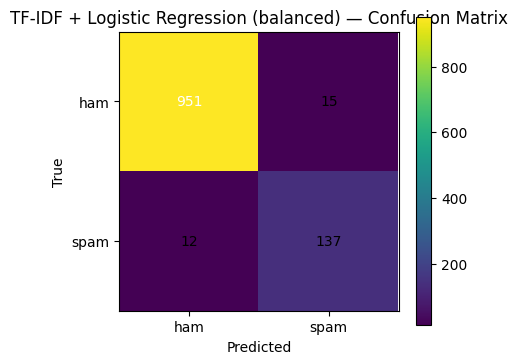


=== TF-IDF + MultinomialNB (sample-weighted) ===
              precision    recall  f1-score   support

         ham     0.9916    0.9731    0.9822       966
        spam     0.8443    0.9463    0.8924       149

    accuracy                         0.9695      1115
   macro avg     0.9179    0.9597    0.9373      1115
weighted avg     0.9719    0.9695    0.9702      1115

Accuracy: 0.9695


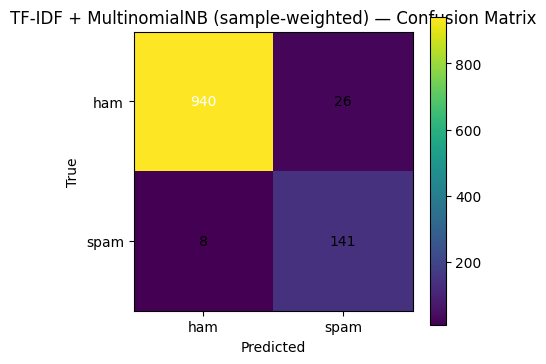

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_class_weight

# Class weights for LR
classes = np.array(['ham','spam'])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train.values)
cw_dict = {c:w for c,w in zip(classes, class_weights)}
print("Class weights (LR):", cw_dict)

# (i) TF-IDF + Logistic Regression
lr_tfidf = LogisticRegression(max_iter=2000, class_weight=cw_dict)
lr_tfidf.fit(Xtr_tfidf, y_train)
pred_lr_tfidf = lr_tfidf.predict(Xte_tfidf)
acc_lr_tfidf = evaluate_and_report(y_test, pred_lr_tfidf, "TF-IDF + Logistic Regression (balanced)")

# (ii) TF-IDF + MultinomialNB with sample weights
# Compute per-sample weight: inverse-frequency weighting
counts = y_train.value_counts().to_dict()
w_per_class = {k: (len(y_train) / (2*counts[k])) for k in counts}  # 2 = num classes
sample_w = y_train.map(w_per_class).values

nb_tfidf = MultinomialNB()
nb_tfidf.fit(Xtr_tfidf, y_train, sample_weight=sample_w)
pred_nb_tfidf = nb_tfidf.predict(Xte_tfidf)
acc_nb_tfidf = evaluate_and_report(y_test, pred_nb_tfidf, "TF-IDF + MultinomialNB (sample-weighted)")


## Step 5B — Word2Vec Mean Embeddings (dense) + SMOTE


=== Word2Vec(avg, SMOTE) + Logistic Regression ===
              precision    recall  f1-score   support

         ham     0.9834    0.9193    0.9502       966
        spam     0.6321    0.8993    0.7424       149

    accuracy                         0.9166      1115
   macro avg     0.8077    0.9093    0.8463      1115
weighted avg     0.9364    0.9166    0.9225      1115

Accuracy: 0.9166


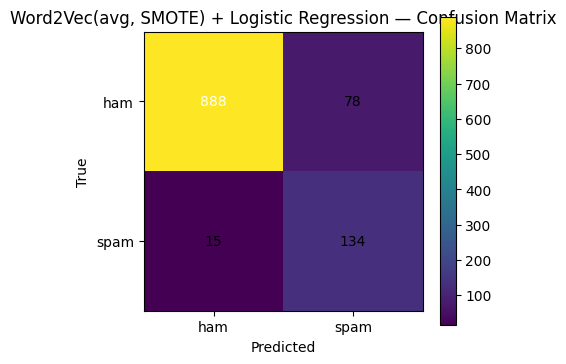


=== Word2Vec(avg, SMOTE) + Random Forest ===
              precision    recall  f1-score   support

         ham     0.9824    0.9803    0.9813       966
        spam     0.8742    0.8859    0.8800       149

    accuracy                         0.9677      1115
   macro avg     0.9283    0.9331    0.9307      1115
weighted avg     0.9679    0.9677    0.9678      1115

Accuracy: 0.9677


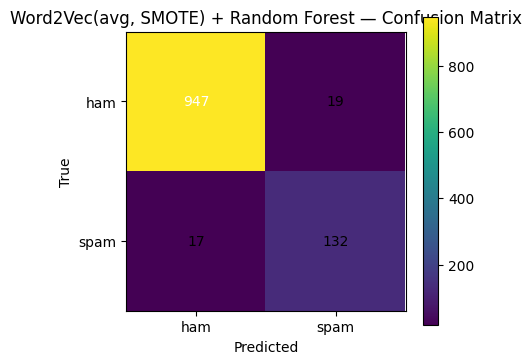

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
lr_w2v = LogisticRegression(max_iter=2000)
lr_w2v.fit(Xtr_w2v_sm, ytr_sm_lab)
pred_lr_w2v = lr_w2v.predict(Xte_w2v)
acc_lr_w2v = evaluate_and_report(y_test, pred_lr_w2v, "Word2Vec(avg, SMOTE) + Logistic Regression")

# Random Forest
rf_w2v = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_w2v.fit(Xtr_w2v_sm, ytr_sm_lab)
pred_rf_w2v = rf_w2v.predict(Xte_w2v)
acc_rf_w2v = evaluate_and_report(y_test, pred_rf_w2v, "Word2Vec(avg, SMOTE) + Random Forest")


## Step 5C — LSTM model (with class weights)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 209ms/step - accuracy: 0.8445 - loss: 0.5851 - val_accuracy: 0.9641 - val_loss: 0.1080
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.9738 - loss: 0.1187 - val_accuracy: 0.9776 - val_loss: 0.0645
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - accuracy: 0.9919 - loss: 0.0372 - val_accuracy: 0.9731 - val_loss: 0.0828
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.9952 - loss: 0.0172 - val_accuracy: 0.9821 - val_loss: 0.0841
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.9974 - loss: 0.0087 - val_accuracy: 0.9798 - val_loss: 0.1050
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step

=== LSTM (class-weighted) ===
              precision    recall  f1-score   support

         ham     0.9847    0.9990    0.9918       966
        spam     0.9926    0.8993    0.9437       149

    accuracy                         0.9857      1115
   macro avg     0.9886    0.9491    0.9677      1115
weighted avg     

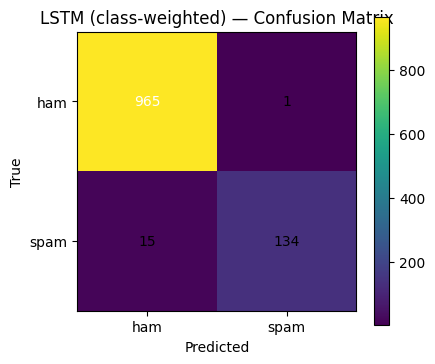

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.backend.clear_session()

vocab_size = min(max_words, len(tokenizer.word_index) + 1)
emb_dim = 100

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    Xtr_pad, y_train_bin,
    validation_split=0.1,
    epochs=5,
    batch_size=64,
    callbacks=[es],
    class_weight=cw_lstm,
    verbose=1
)

proba_lstm = model.predict(Xte_pad).ravel()
pred_lstm_bin = (proba_lstm >= 0.5).astype(int)
pred_lstm_lab = np.where(pred_lstm_bin==1, 'spam', 'ham')

acc_lstm = evaluate_and_report(y_test, pred_lstm_lab, "LSTM (class-weighted)")


## Step 6 — Compare models

In [ ]:
import pandas as pd

results = pd.DataFrame({
    'Model': [
        'TF-IDF + LogisticRegression (balanced)',
        'TF-IDF + MultinomialNB (sample-weighted)',
        'Word2Vec(avg, SMOTE) + LogisticRegression',
        'Word2Vec(avg, SMOTE) + RandomForest',
        'LSTM (class-weighted)'
    ],
    'Accuracy': [
        acc_lr_tfidf,
        acc_nb_tfidf,
        acc_lr_w2v,
        acc_rf_w2v,
        acc_lstm
    ]
}).sort_values('Accuracy', ascending=False).reset_index(drop=True)

results


,Model,Accuracy
0,LSTM (class-weighted),0.985650
1,TF-IDF + LogisticRegression (balanced),0.975785
2,TF-IDF + MultinomialNB (sample-weighted),0.969507
3,"Word2Vec(avg, SMOTE) + RandomForest",0.967713
4,"Word2Vec(avg, SMOTE) + LogisticRegression",0.916592


from matplotlib import pyplot as plt
results['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## step 7- Save best lightweight model for Streamlit

In [ ]:
import joblib, os
os.makedirs('artifacts', exist_ok=True)
joblib.dump(tfidf, 'artifacts/tfidf_vectorizer.pkl')
joblib.dump(lr_tfidf, 'artifacts/logreg_tfidf.pkl')
print("Saved TF-IDF vectorizer and LR model to /content/artifacts")

# Also save LSTM (optional)
model.save('artifacts/lstm_model.h5')
with open('artifacts/tokenizer.json', 'w') as f:
    f.write(tokenizer.to_json())
print("Saved LSTM + tokenizer.")


Saved TF-IDF vectorizer and LR model to /content/artifacts
Saved LSTM + tokenizer.


## Downloading models

In [ ]:
from google.colab import files

files.download("artifacts/tfidf_vectorizer.pkl")
files.download("artifacts/logreg_tfidf.pkl")
files.download("artifacts/lstm_model.h5")
files.download("artifacts/tokenizer.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **📑 Spam-Ham SMS Classification Project Report**
### 🔹 Introduction

The rise of mobile communication has led to an increase in unsolicited SMS messages, commonly known as spam. Filtering spam messages from legitimate (ham) messages is an important Natural Language Processing (NLP) task.

This project focuses on building machine learning and deep learning models for classifying SMS messages into spam or ham. Different text representation techniques such as TF-IDF, Word2Vec, and LSTM sequences were used, followed by model training and performance evaluation.

### 🔹 Workflow Overview
✅ Step 0 — Setup

Installed required Python libraries (numpy, pandas, sklearn, gensim, tensorflow, nltk)

Ensured reproducibility by fixing random seeds

Downloaded NLTK resources (stopwords, punkt, wordnet)

✅ Step 1 — Load Dataset

The dataset contained 5,572 SMS messages

After cleaning and normalization, the final dataset distribution was:

Label	Count
Ham	4825
Spam	747
✅ Step 2 — Text Cleaning

Applied preprocessing steps:

Converted to lowercase

Removed URLs, emails, numbers, punctuation

Tokenized text

Removed stopwords

Lemmatized words

📌 A new column clean was created for preprocessed text.

✅ Step 3 — Train/Test Split

Stratified train-test split:

Training set: 4457 samples

Testing set: 1115 samples

Distribution preserved:

Train → Ham: 3859, Spam: 598

Test → Ham: 966, Spam: 149

✅ Step 4 — Feature Engineering

TF-IDF Features

N-grams (1,2), min_df=2, max_df=0.95

Resulting feature space: 7073 dimensions

Word2Vec Embeddings

Vector size = 100

Used SMOTE to balance training set

LSTM Sequences

Tokenized texts → padded sequences (max_len=60)

Applied class weights to handle imbalance

✅ Step 5 — Model Training
🔸 A. TF-IDF Based Models

Logistic Regression (balanced class weights) → 97.58%

Multinomial Naive Bayes (sample-weighted) → 96.95%

🔸 B. Word2Vec + SMOTE Models

Logistic Regression → 91.66%

Random Forest → 96.77%

🔸 C. Deep Learning Model (LSTM)

Bidirectional LSTM with Embedding layer

Used class weights for imbalance

Accuracy: 98.57% ✅ (Best)

✅ Step 6 — Model Comparison
Model	Accuracy
LSTM (class-weighted)	98.57%
TF-IDF + Logistic Regression (balanced)	97.58%
TF-IDF + MultinomialNB (sample-weighted)	96.95%
Word2Vec(avg, SMOTE) + Random Forest	96.77%
Word2Vec(avg, SMOTE) + Logistic Regression	91.66%

📌 Best Model → LSTM (class-weighted) with 98.57% accuracy

✅ Step 7 — Model Saving for Deployment

Saved TF-IDF vectorizer and Logistic Regression model as lightweight baseline models

Also saved LSTM model + tokenizer for advanced deployment

Files exported:

tfidf_vectorizer.pkl

logreg_tfidf.pkl

lstm_model.h5

tokenizer.json

### 🔹 Conclusion

Multiple approaches were tested for spam detection using both classical ML algorithms and deep learning models

The LSTM (Bi-directional with class weights) achieved the highest performance (98.57% accuracy), outperforming traditional ML models

The project demonstrates how feature engineering, imbalance handling, and deep learning can significantly improve spam detection